## Building an ARIMA model 
General steps for forecasting using ARMA models:
- Plot the data and identify any unusual observations.
- If necessary, transform the data (using a Box-Cox transformation) to stabilise the variance.
- If the data are non-stationary, take first differences of the data until the data are stationary.
- Examine the ACF/PACF: is an ARIMA (p,d,0) or ARIMA (0,d,q) model appropriate? 
- Try chosen model(s), and use the AICc to search for a better mdoel
- Check residuals from chosen model by plotting the ACF of the residuals, and doing a portmanteau test of the residuals. If they do not look like white noise, try modified model
- Once residuals look like white noise, calculate forecasts. 

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from statsmodels.tsa import stattools

In [2]:
def patch_missing_dates(df):
    missing = pd.date_range(start=df.index.min(),  end=df.index.max()).difference(df.index)
    df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max()),method='ffill')
    if not missing.empty:
        print('dates missing:', missing)
        print('filling with forward fill - propagating last valid observation to next')
    return df 


In [5]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = pd.DataFrame(target_df['SoCal_TOTAL']).join(predictor_df).sort_index(ascending=True)
train_df = df[df.index<pd.to_datetime('3/1/21')]
test_df = df[df.index>=pd.to_datetime('3/1/21')]

In [6]:
region = 'SoCal' # can be SD or SoCal
# recapitulating vbDLFM with lags
targets_train = train_df[region+ '_TOTAL']
targets_test = test_df[region+ '_TOTAL']
predictors_train = train_df[[region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7','Holiday']]

predictors_test = test_df[[region + '_HDD',region + '_t-1_HDD', region + '_t-2_HDD',region + '_t-3_HDD',
                 region + '_CDD',region + '_t-1_CDD', 
                 region+'_HDD_7', region + '_t-1_HDD_7','Holiday']]

# fixnan dates
predictors_train = patch_missing_dates(predictors_train.dropna()).asfreq('D')
predictors_test = patch_missing_dates(predictors_test.dropna().asfreq('D'))


dates missing: DatetimeIndex(['2017-04-12', '2018-08-08'], dtype='datetime64[ns]', freq=None)
filling with forward fill - propagating last valid observation to next


In [21]:
# smax = SARIMAX(endog=targets_train, exog=predictors_train, freq='D', 
#                order=(2, 1, 1), seasonal_order=(0,0,0,0),
#               mle_regression=True).fit(maxiter=200)
smax = SARIMAX(endog=targets_train, exog=predictors_train, freq='D', 
              mle_regression=True).fit(maxiter=200)
smax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            SoCal_TOTAL   No. Observations:                 1765
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -9322.420
Date:                Fri, 06 Aug 2021   AIC                          18666.839
Time:                        13:36:07   BIC                          18727.074
Sample:                    05-01-2016   HQIC                         18689.096
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
SoCal_HDD          26.1753      0.704     37.207      0.000      24.796      27.554
SoCal_t-1_HDD      15.6043      0.803     19.428      0.000      14.030      17.178
SoCal_t-2_HDD       3.8372      0.474      8.100      0.000       2.909       4.766
SoCal_t-3_HDD       1.0361      0.472      2.196      0.028       0.112       1.961
SoCal_CDD          -3.4895      1.152     -3.028      0.002      -5.748      -1.231
SoCal_t-1_CDD      -2.1150      1.230     -1.719      0.086      -4.526       0.296
SoCal_HDD_7        24.3958      1.064     22.931      0.000      22.311      26.481
SoCal_t-1_HDD_7    -0.2288      1.180     -0.194      0.846      -2.542       2.085
Holiday             5.9776      3.581      1.669      0.095      -1.041      12.996
ar.L1               0.9979      0.001    760.607      0.000       0.995       1.001
sigma2           2258.8795     38.830     58.174      0.000    2182.775    2334.984
===================================================================================
Ljung-Box (L1) (Q):                  31.19   Jarque-Bera (JB):              3636.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
smax.mle_retvals

{'fopt': 5.281824111402651,
 'gopt': array([ 4.97060171e-06,  1.97974970e-06, -6.67643718e-07,  6.35047570e-08,
        -3.42899042e-06,  2.33999486e-06,  2.03970174e-06,  3.16777715e-06,
        -1.22852839e-06,  9.22151244e-06, -7.68540786e-07]),
 'fcalls': 372,
 'warnflag': 0,
 'converged': True,
 'iterations': 24}

In [9]:
arima_fit = pm.auto_arima(y=targets_train, X=predictors_train, seasonal=True)
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -9168.397
Date:                Fri, 06 Aug 2021   AIC                          18362.795
Time:                        13:28:18   BIC                          18433.974
Sample:                    05-01-2016   HQIC                         18389.097
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
SoCal_HDD          26.9956      0.680     39.672      0.000      25.662      28.329
SoCal_t-1_HDD      16.1481      0.823     19.620      0.000      14.535      17.761
SoCal_t-2_HDD       5.0159      0.474     10.575      0.000       4.086       5.946
SoCal_t-3_HDD       2.4769      0.460      5.380      0.000       1.574       3.379
SoCal_CDD          -3.7576      1.321     -2.844      0.004      -6.347      -1.168
SoCal_t-1_CDD      -2.4159      0.989     -2.444      0.015      -4.353      -0.478
SoCal_HDD_7        24.6795      1.067     23.126      0.000      22.588      26.771
SoCal_t-1_HDD_7     0.7454      1.192      0.625      0.532      -1.592       3.082
Holiday             5.7090      3.979      1.435      0.151      -2.090      13.508
ar.L1               0.5360      0.022     24.893      0.000       0.494       0.578
ar.L2              -0.1522      0.018     -8.621      0.000      -0.187      -0.118
ma.L1              -0.8212      0.018    -46.676      0.000      -0.856      -0.787
sigma2           1905.5387     33.518     56.852      0.000    1839.845    1971.232
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3062.74
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

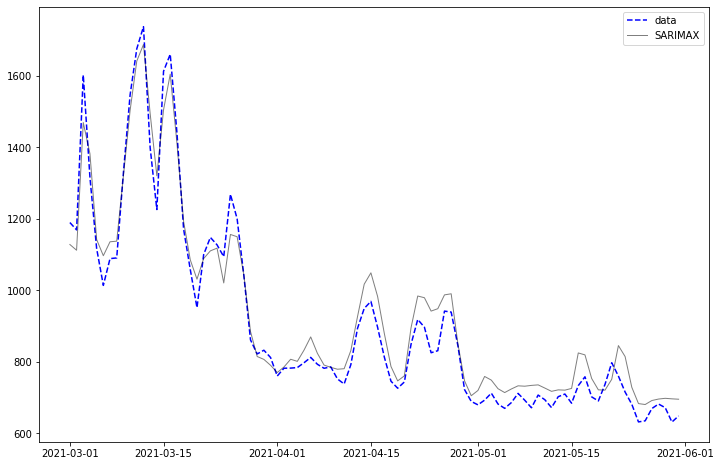

In [23]:
pred_means =smax.predict(test_df.index.min(), test_df.index.max(), exog=predictors_test, full_results=True, alpha=0.05)

# You can then plot it (import matplotlib first)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
#Actual data
ax.plot(test_df['SoCal_TOTAL'].astype('float64'), '--', color="blue", label='data')
# Means
ax.plot(pred_means, lw=1, color="black", alpha=0.5, label='SARIMAX')
ax.legend(loc='upper right')
plt.draw()

In [ ]:
pct_errors = (1-(pred_means/test_df['SoCal_TOTAL']))*100



In [ ]:
# identify whether target series is stationary by checking acf plot
def acf_plots(data, nlags, seasonal_m):
    acf_values = []
    for k in np.arange(0,nlags+1):
        acf_values.append(data.diff(seasonal_m).dropna().autocorr(lag=k))
    acf_5cv = 1.96/np.sqrt(len(df['SoCal_TOTAL']) - np.arange(0, nlags+1))
    pacf_values = stattools.pacf(data, nlags=nlags)
    
    print(len(acf_values), len(pacf_values))
    
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    sns.lineplot(data=data, ax=ax1)

    pd.plotting.autocorrelation_plot(data, ax=ax2)
    ax2.set_title('Original ACF'), ax2.set_ylim([-1, 1]), ax2.set_xlim([0, nlags])

    sns.lineplot(data=pacf_values, ax=ax3)
    ax3.plot(np.arange(0, nlags+1), acf_5cv, 'k--')
    ax3.plot(np.arange(0, nlags+1), acf_5cv*-1, 'k--')
    ax3.set_title('PACF'), ax3.set_xlabel('Lag'), ax3.set_xlim([0, nlags])

    plt.tight_layout(), plt.show()
    
    marks_df = pd.DataFrame({'ACF': acf_values,
                             'PACF': pacf_values,
                             '5CV': acf_5cv,})
    
    adf_p = stattools.adfuller(data)[1]
    print('stationary if sig:', adf_p)
    return marks_df

In [ ]:
acf_plots(df['SoCal_TOTAL'], nlags=100, seasonal_m=365) #not sig
seasonal_diff =df['SoCal_TOTAL'].diff(365).dropna()
marks_df = acf_plots(seasonal_diff, nlags=100, seasonal_m=365) #sig

In [ ]:
np.diff(marks_df.index[marks_df['PACF']>marks_df['5CV']]).cumsum()

In [ ]:
# find D via Canova Hanson test to minimize search params for auto_arima seasonal component
pm.arima.utils.nsdiffs(df['SoCal_TOTAL'], 
                      m=365,
                      max_D=12,
                      test='ch')

In [ ]:
# NOTE: Seasonal order cannot exceed 200. For daily data with yearly seasonality (i.e. m=365) 
# seasonality needs to be resolve via FFT added on top of an ARIMA process
# see note in https://robjhyndman.com/hyndsight/longseasonality/

df_test = df[df.index >= pd.to_datetime('4/15/21')] 
df_train = df[df.index < pd.to_datetime('4/15/21')]
arima_fit = pm.auto_arima(df_train['SoCal_TOTAL'], 
                          start_p=25, max_p=33,
                          d=0, 
                          seasonal=True, m=30,
                          start_P=3, max_P=7,
                          D=1, 
                          stepwise=True)
arima_fit.summary()

In [ ]:
days_to_forecast = pd.date_range(start=df_train.index.max(), end = df_train.index.max() + pd.DateOffset(months=6), freq='1d')
predictions = pd.DataFrame({'ARIMA_predict': arima_fit.predict(len(days_to_forecast))})
predictions.index=days_to_forecast

compare_df = pd.concat([df_test['SoCal_TOTAL'], predictions], axis=1).rename(columns={'SoCal_TOTAL': 'Test'})
sns.lineplot(data=df_train['SoCal_TOTAL'], color='k', label='Train')
sns.lineplot(data=compare_df, )
plt.xlim([df_train.index.max() - pd.DateOffset(months=1), predictions.index.max()])
plt.show()

In [ ]:
# transform target data to stationary

lb_test = sm.stats.acorr_ljungbox(df[forecast_column+'_residuals'], lags=[27])

df['SoCal_TOTAL']